## Tfidf Featurization on Question Pairs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

C:\Users\arjun\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Read the final_features data frame
df_nlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df_ppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

df1 = df_nlp.drop(['qid1','qid2'],axis=1)
df2 = df_ppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df  = df1.merge(df2, on='id',how='left')

In [3]:
df.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [4]:
df.head(5)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [5]:
#Remove the first row 
#data.drop(data.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

### Random train test split( 70:30)

In [6]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [7]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 28)
Number of data points in test data : (121287, 28)


In [8]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [9]:
X_train['question1']

205672                       how much should i tip waiters 
386000    what is the best in ear headphones to buy unde...
224578    does jimmy wales earn anything from wikipedia ...
211984    what are some unusual aspects about politics a...
45300     how do i prepare well for campus placements exam 
31988     what is the difference between logical reasoni...
319447    are there any coding camps for competitive pro...
268364                         how can i cure my knee pain 
282280       do we really need reservation system in india 
209099    how can i get a complete list of all my gmail ...
300793               can i make an android app with python 
202962    when did you first have sex  how many people h...
24948     how can i lose my belly fat without losing my ...
31550     should i answer this  please provide any addit...
292910            what is the best account management tool 
331188        is downloading from torrent illegal in india 
255130    what is a  desktop hard drive 

In [10]:
X_train.head()

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
205672,how much should i tip waiters,how much should i tip waiters in the u s,0.999967,0.749981,0.999967,0.499992,0.999983,0.599994,0.0,1.0,...,2,30,42,6,9,5.0,15.0,0.333333,3,1
386000,what is the best in ear headphones to buy unde...,which is the best in ear headphones under rs 1k,0.999980,0.833319,0.799984,0.666656,0.899991,0.749994,1.0,0.0,...,1,57,50,12,10,8.0,22.0,0.363636,2,0
224578,does jimmy wales earn anything from wikipedia ...,does jimmy wales earn money from wikipedia,0.799984,0.571420,0.999950,0.249997,0.857131,0.374998,0.0,1.0,...,5,100,43,16,7,6.0,22.0,0.272727,7,3
211984,what are some unusual aspects about politics a...,what are some unusual aspects about politics a...,0.799984,0.799984,0.999983,0.999983,0.909083,0.909083,0.0,1.0,...,2,73,71,11,11,10.0,22.0,0.454545,11,7
45300,how do i prepare well for campus placements exam,how should i prepare myself for campus placeme...,0.999967,0.599988,0.749981,0.599988,0.749991,0.666659,0.0,1.0,...,3,49,50,9,8,5.0,17.0,0.294118,6,0


In [11]:
#Tfidf Vectorizer for Question-1
dfq1_tfidf = TfidfVectorizer()

train_q1_tfidf = dfq1_tfidf.fit_transform(X_train['question1'].values.astype('U'))
test_q1_tfidf = dfq1_tfidf.transform(X_test['question1'].values.astype('U'))

In [12]:
print(train_q1_tfidf.shape)
print(test_q1_tfidf.shape)

(283003, 58125)
(121287, 58125)


In [13]:
#Tfidf Vectorizer for Question-2
dfq2_tfidf = TfidfVectorizer()

train_q2_tfidf = dfq2_tfidf.fit_transform(X_train['question2'].values.astype('U'))
test_q2_tfidf = dfq2_tfidf.transform(X_test['question2'].values.astype('U'))

In [14]:
print(train_q2_tfidf.shape)
print(test_q2_tfidf.shape)

(283003, 53814)
(121287, 53814)


In [15]:
#Combining Question-1 and Question-2
train_tfidf = hstack((train_q1_tfidf,train_q2_tfidf))
test_tfidf = hstack((test_q1_tfidf,test_q2_tfidf))

In [16]:
#Dropping question-1 and question-2 and Replacing with tfidf values
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [17]:
#Combining all train nlp features, adv features and tfidf features
X_train = hstack((X_train, train_tfidf)).tocsr()

In [18]:
#Combining all test nlp features, adv features and tfidf features
X_test = hstack((X_test, test_tfidf)).tocsr()

In [19]:
print(X_train.shape)
print(X_test.shape)

(283003, 111965)
(121287, 111965)


In [20]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.889276548941577


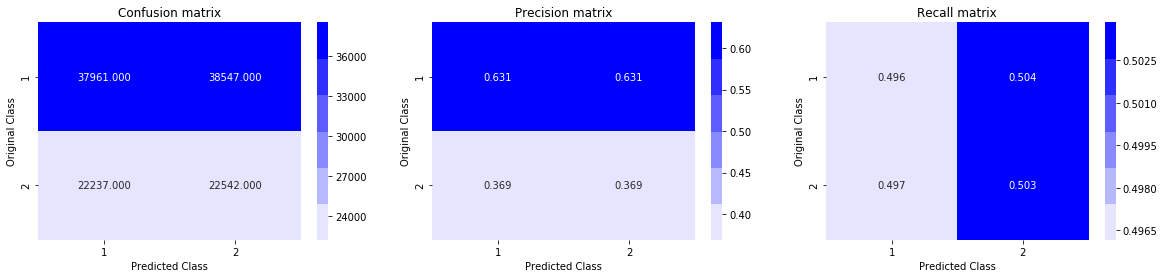

In [21]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### ML Models:

### Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43958511941185685
For values of alpha =  0.0001 The log loss is: 0.43930371656391404
For values of alpha =  0.001 The log loss is: 0.43705895217675694
For values of alpha =  0.01 The log loss is: 0.4416431114809865
For values of alpha =  0.1 The log loss is: 0.45788347509651484
For values of alpha =  1 The log loss is: 0.4916270374250278
For values of alpha =  10 The log loss is: 0.5442776756786557


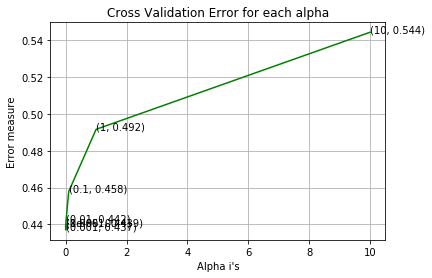

For values of best alpha =  0.001 The train log loss is: 0.4380147906313432
For values of best alpha =  0.001 The test log loss is: 0.43705895217675694
Total number of data points : 121287


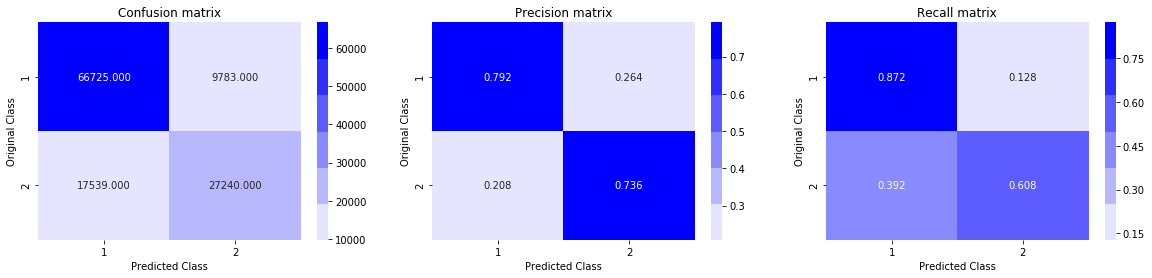

In [22]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.44226364788182215
For values of alpha =  0.0001 The log loss is: 0.486073138321924
For values of alpha =  0.001 The log loss is: 0.5082223821555371
For values of alpha =  0.01 The log loss is: 0.5195982509691487
For values of alpha =  0.1 The log loss is: 0.5219051962093454
For values of alpha =  1 The log loss is: 0.5923182282261674
For values of alpha =  10 The log loss is: 0.6404004751498796


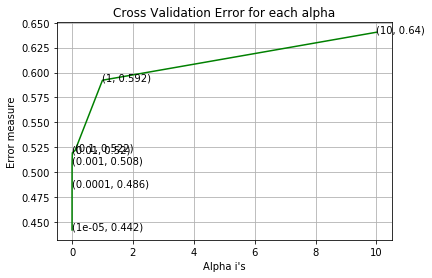

For values of best alpha =  1e-05 The train log loss is: 0.4423425506205144
For values of best alpha =  1e-05 The test log loss is: 0.44226364788182215
Total number of data points : 121287


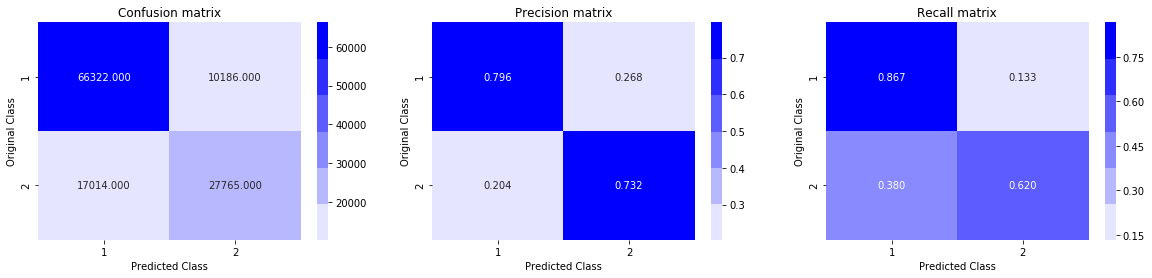

In [23]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost

In [24]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684865	valid-logloss:0.684852
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615484	valid-logloss:0.615349
[20]	train-logloss:0.564855	valid-logloss:0.564622
[30]	train-logloss:0.526357	valid-logloss:0.526093
[40]	train-logloss:0.497143	valid-logloss:0.496858
[50]	train-logloss:0.474222	valid-logloss:0.473904
[60]	train-logloss:0.455926	valid-logloss:0.455597
[70]	train-logloss:0.441286	valid-logloss:0.440943
[80]	train-logloss:0.429598	valid-logloss:0.429219
[90]	train-logloss:0.419996	valid-logloss:0.419593
[100]	train-logloss:0.412072	valid-logloss:0.411643
[110]	train-logloss:0.405339	valid-logloss:0.404904
[120]	train-logloss:0.399713	valid-logloss:0.399277
[130]	train-logloss:0.39489	valid-logloss:0.394452
[140]	train-logloss:0.391003	valid-logloss:0.390619
[150]	train-logloss:0.387506	valid-logloss:0.387153
[160]	train-logloss:0.384368	

Total number of data points : 121287


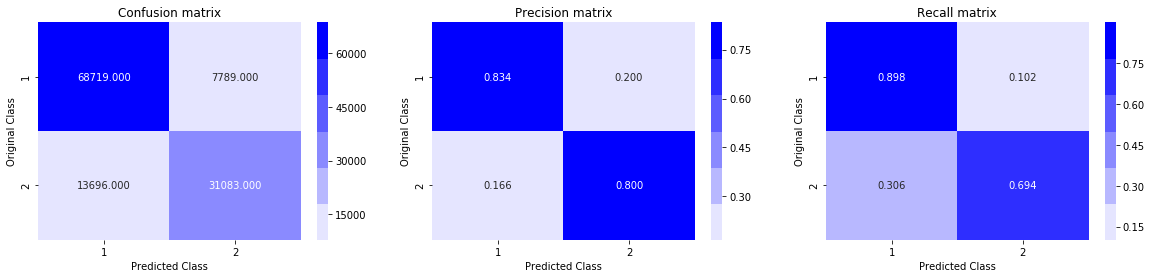

In [25]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Results:

#### 1. Logistic Regression(Test Logloss) = 0.43705
#### 2. Linear SVM(Test Logloss) = 0.4423
#### 3. XGboost(Test Logloss) = 0.3556